In [91]:
import numpy as np
from skimage import io,color
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

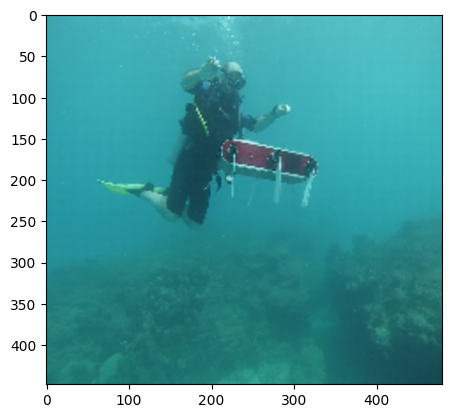

In [92]:
img=io.imread("../images/d_r_47_.jpg")
plt.imshow(img)
plt.show()

In [93]:
# filters
laplacian_filter=np.array([[0,1,0],[1,-4,1],[0,1,0]])
x_grad=np.array([[-1,1]])
y_grad=np.array([[-1],[1]])

In [94]:
# step 1 color correction
def make_correction(channel:np.ndarray,mu:float)->np.ndarray:
    channel=channel/255.0
    channel_mean=channel.mean()
    channel_var=channel.std()
    channel_corrected=(255.0/2)*(1 + (channel-channel_mean)/(mu*channel_var))
    channel_corrected=np.clip(channel_corrected,0,255)
    return channel_corrected.astype(np.uint8)

In [95]:
def shrink(x:np.ndarray,eps:float)->float:
    norm=np.linalg.norm(x,ord=2)
    if norm ==0:
        return np.zeros(shape=x.shape)
    ans=x*np.max(norm-eps,0)/norm
    return ans

In [96]:
# equation 15
def update_d_h(R:np.ndarray,m_h:np.ndarray,lamda1:float)->np.ndarray:
    return shrink(np.abs(convolve2d(R,x_grad,mode='same'))+m_h,1/(2*lamda1))

def update_d_v(R:np.ndarray,m_v:np.ndarray,lamda1:float)->np.ndarray:
    return shrink(np.abs(convolve2d(R,y_grad,mode='same'))+m_v,1/(2*lamda1))

def update_h(R:np.ndarray,n_k:np.ndarray,lamda2:float)->np.ndarray:
    return shrink(np.abs(convolve2d(R,laplacian_filter,mode='same'))+n_k,1/(2*lamda2))

def update_m_h(R:np.ndarray,m_h:np.ndarray,d_h:np.ndarray)->np.ndarray:
    return np.abs(convolve2d(R,x_grad,mode='same'))+m_h-d_h

def update_m_v(R:np.ndarray,m_v:np.ndarray,d_v:np.ndarray)->np.ndarray:
    return np.abs(convolve2d(R,y_grad,mode='same'))+m_v-d_v

def update_n_k(R:np.ndarray,n_k:np.ndarray,h_k:np.ndarray)->np.ndarray:
    return np.abs(convolve2d(R,laplacian_filter,mode='same'))+n_k-h_k

In [97]:
# 𝜱1
def phi_1(d_h:np.ndarray,m_h:np.ndarray,d_v:np.ndarray,m_v:np.ndarray)->np.ndarray:
    x=convolve2d(np.fft.fft(d_h-m_h),np.conj(np.fft.fft(x_grad).transpose()),mode='same')+convolve2d(np.fft.fft(d_v-m_v),np.conj(np.fft.fft(y_grad).transpose()),mode='same')
    return x

In [98]:
# 𝜱2
def phi_2(h_k:np.ndarray,n_k:np.ndarray)->np.ndarray:
    x=convolve2d(np.fft.fft(h_k-n_k),np.conj(np.fft.fft(laplacian_filter).transpose()),mode='same')
    return x

In [99]:
# shi 1
def shi_1()->float:
    fft_d_x=np.fft.fft(x_grad)
    conjugate_fft_d_x=np.conjugate(fft_d_x)
    fft_d_y=np.fft.fft(y_grad)
    conjugate_fft_d_y=np.conjugate(fft_d_y)
    return (fft_d_x.dot(conjugate_fft_d_x.T)).squeeze()+(fft_d_y.T.dot(conjugate_fft_d_y)).squeeze()

In [100]:
# shi 2
def shi_2()->float:
    fft_laplacian=np.fft.fft(laplacian_filter).reshape(9,1)
    conj_transpose_fft=np.conj(fft_laplacian.T).reshape(1,9)
    return conj_transpose_fft.dot(fft_laplacian)

In [101]:
def update_R(L:np.ndarray,
             I:np.ndarray,
             lambda1:float,
             lambda2:float,
             nu1:float,
             nu2:float,
             d_h:np.ndarray,
             m_h:np.ndarray,
             d_v:np.ndarray,
             m_v:np.ndarray,
             h_k:np.ndarray,
             n_k:np.ndarray)->np.ndarray:
    I=np.nan_to_num(I,nan=255.0)
    I=np.where(I==0,0.00001,I)
    fft_L_I=np.fft.fft(L/I)
    numerator=fft_L_I+nu1*lambda1*phi_1(d_h,m_h,d_v,m_v)+nu2*lambda2*phi_2(h_k,n_k)
    denominator=np.fft.fft([1])+nu1*lambda1*shi_1()+nu2*lambda2*shi_2()
    R=(np.fft.ifft(numerator/denominator)).real
    return R.clip(0.00001,1)

In [102]:
def update_I(L:np.ndarray,
             R:np.ndarray,
             nu3:float,
             nu4:float)->np.ndarray:
    R=np.nan_to_num(R,nan=1)
    numerator=np.fft.fft(L/R)
    denominator=np.fft.fft([1])+nu3*shi_1()+nu4*shi_2()
    I=(np.fft.ifft(numerator/denominator)).real
    return I.clip(0.00001,255)

In [103]:
def get_corrected_image(img:np.ndarray,mu:float)->np.ndarray:
    R,G,B=img[:,:,0],img[:,:,1],img[:,:,2]
    R_corrected,G_corrected,B_corrected=make_correction(R,mu),make_correction(G,mu),make_correction(B,mu)
    corrected_image=np.stack([R_corrected,G_corrected,B_corrected],axis=-1)
    return corrected_image


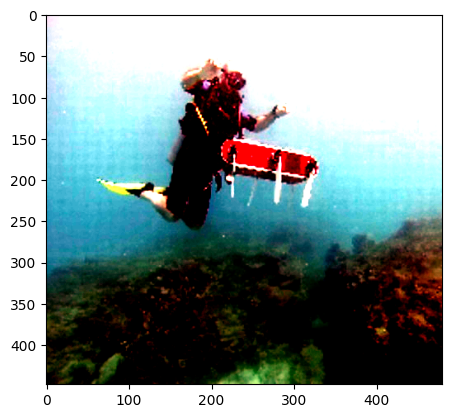

In [104]:
corrected_img=get_corrected_image(img,0.75)
plt.imshow(corrected_img)
plt.show()

In [105]:
hsv_img=color.rgb2hsv(corrected_img)

In [106]:
H,S,V=hsv_img[:,:,0],hsv_img[:,:,1],hsv_img[:,:,2]

In [107]:
nu1=1
nu2=1e-3
nu3=1e-5
nu4=1e-3
lambda1=1e-4
lambda2=1e-3

In [108]:
L=255*V
I=gaussian_filter(L,sigma=2)

In [109]:
hist,bins=np.histogram(L.flatten(),256,[0,255])

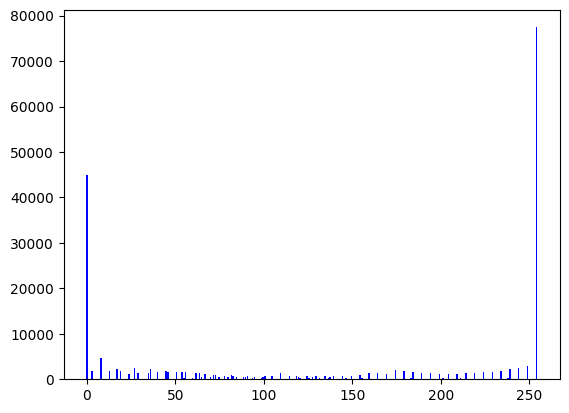

In [110]:
plt.bar(bins[:-1],hist,color='b')
plt.show()

In [111]:
R=np.zeros(shape=L.shape)
m_h=np.zeros(shape=L.shape)
m_v=np.zeros(shape=L.shape)
n=np.zeros(shape=L.shape)
k=1

In [112]:
# 1st iteration
d_h=update_d_h(R,m_h,lambda1)

In [113]:
d_v=update_d_v(R,m_v,lambda1)
h=update_h(R,n,lambda2)

In [114]:
I=np.where(I==0,0.00001,I)
R1=update_R(L,I,lambda1,lambda2,nu1,nu2,d_h,m_h,d_h,m_v,h,n)
R1=np.clip(R1,0,1)

In [115]:
m_h=update_m_h(R1,m_h,d_h)
m_v=update_m_v(R1,m_v,d_v)
n=update_n_k(R1,n,h)

In [116]:
R1=np.clip(R1,0,1)
R1=np.where(R1==0,0.00001,R1)
I=update_I(L,R1,nu3,nu4)
I=np.clip(I,0,255)

In [117]:
I.max(),I.min()

(240.71118615927426, 1e-05)

In [118]:
I=np.maximum(I,L)
for i in range(4):
    d_h=update_d_h(R,m_h,lambda1)
    d_v=update_d_v(R,m_v,lambda1)
    h=update_h(R,n,lambda2)
    R1=update_R(L,I,lambda1,lambda2,nu1,nu2,d_h,m_h,d_h,m_v,h,n)
    R1=np.clip(R1,0,1)
    R1=np.where(R1==0,0.00001,R1)
    m_h=update_m_h(R1,m_h,d_h)
    m_v=update_m_v(R1,m_v,d_v)
    n=update_n_k(R1,n,h)
    I=update_I(L,R1,nu3,nu4)
    I=np.clip(I,0,255)
    I=np.where(I==0,0.00001,I)
    I=np.maximum(I,L)
    

In [119]:
R1.max(),R1.min(),I.max(),I.min()

(1.0, 1e-05, 255.0, 1e-05)

In [120]:
I_enhanced=(I*R1)/255

In [121]:
I_enhanced.max(),I_enhanced.min()

(1.0, 3.921568627450981e-13)

In [122]:
enhanced_hsv=np.zeros(shape=hsv_img.shape)

In [123]:
# I_enhanced=255*np.power(I_enhanced/255,1/2.2)

In [124]:
enhanced_hsv[:,:,0],enhanced_hsv[:,:,1],enhanced_hsv[:,:,2]=H,S,I_enhanced

In [125]:
enhanced_img=color.hsv2rgb(enhanced_hsv)

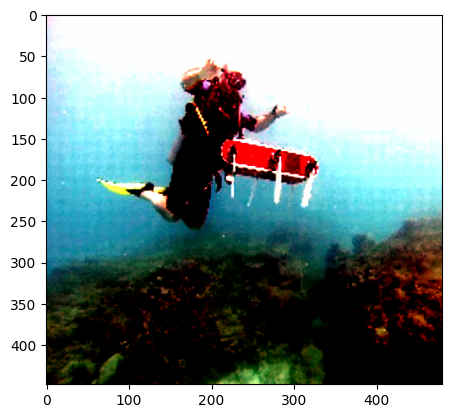

In [126]:
plt.imshow(enhanced_img)
plt.show()